# Relevance Vector Machine 

The relevance vector machine is a probabilisic linear model in which the prior weights are taken to be normally distibuted with mean zero and a diagonal matrix.

$$
\begin{align}
    p({\bf w} | {\bf t}, {\bf \alpha}, {\bf \beta}) &\propto p({\bf w}| {\bf \alpha}) p({\bf t}| y({\bf x}), \beta)\\
    &= \mathcal{N}({\bf w}|{\bf 0}, A) \prod_{n=1}^N\mathcal{N}(t_n|y(x_n), \beta^{-1})
\end{align}
$$

Where $A = \text{diag}(\alpha_1, \ldots, \alpha_M)$

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn, seed, uniform
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import multivariate_normal

In [138]:
%config InlineBackend.figure_format = "retina"

## The Test Data

In [15]:
nobs = 20
X = np.linspace(0, 1, nobs) + uniform(0, 0.01, nobs)
y = np.sin(2 * np.pi * X) + randn(nobs) * 0.3

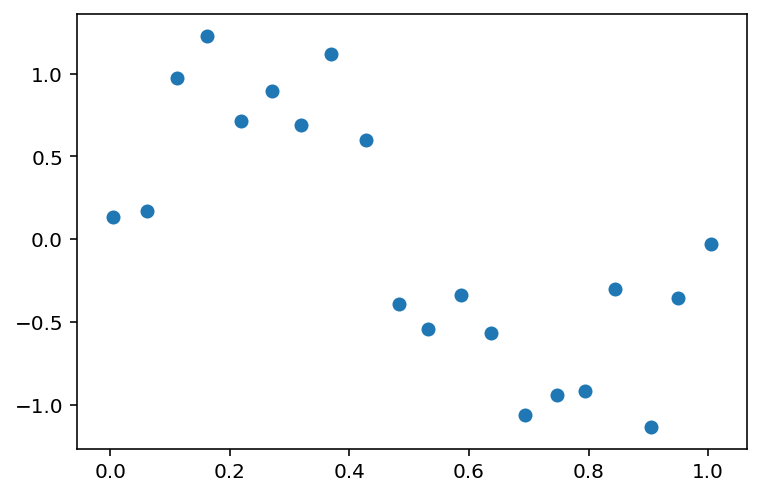

In [139]:
plt.scatter(X, y)

### Polynomial feature matrix

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
Phi = poly.fit_transform(X[:, np.newaxis])

seed(164)
alpha = np.abs(randn(Phi.shape[1]) * 0.5)
beta, *_ = randn(1) * 0.5


A = np.identity(len(alpha)) * alpha
Sigma = np.linalg.inv(A + beta * Phi.T @ Phi)
m = beta * Sigma @ Phi.T @ y[:, np.newaxis]

mvn = multivariate_normal(mean=m.ravel(), cov=Sigma)

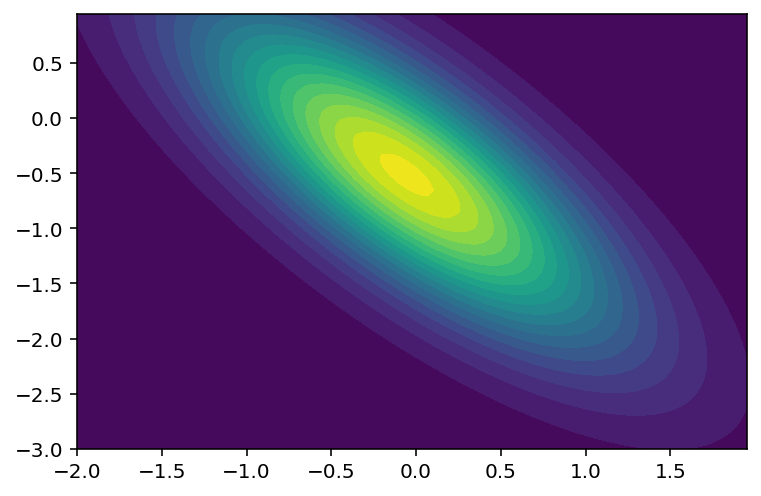

In [261]:
Xtest = np.mgrid[-2:2:0.05, -3:1:0.05]
_, nx, ny = Xtest.shape

Z = Xtest.reshape(2, -1).T
Z = mvn.pdf(Z).T.reshape(1, nx, ny)[0]

plt.contourf(*Xtest, Z, levels=20)

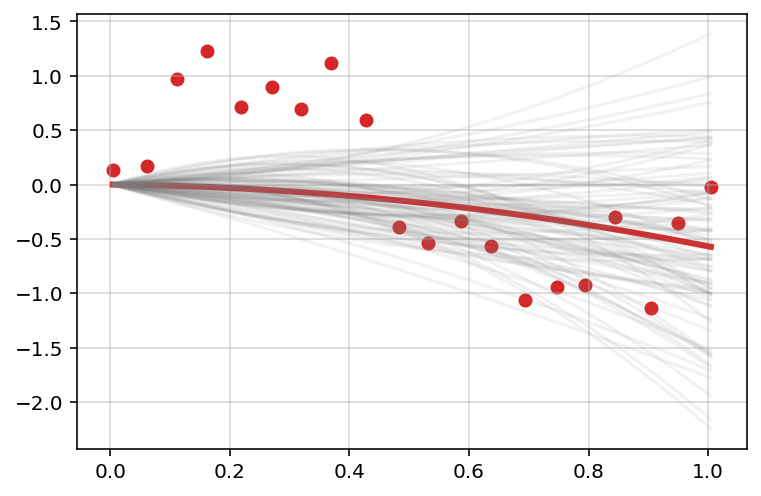

In [262]:
plt.scatter(X, y, c="tab:red")
plt.plot(X, Phi @ mvn.mean[:, np.newaxis], c="tab:red", linewidth=3)
plt.plot(X, Phi @ mvn.rvs(100).T, c="tab:gray", alpha=0.1)
plt.grid(alpha=0.5);

## Radial Basis Function Kernel

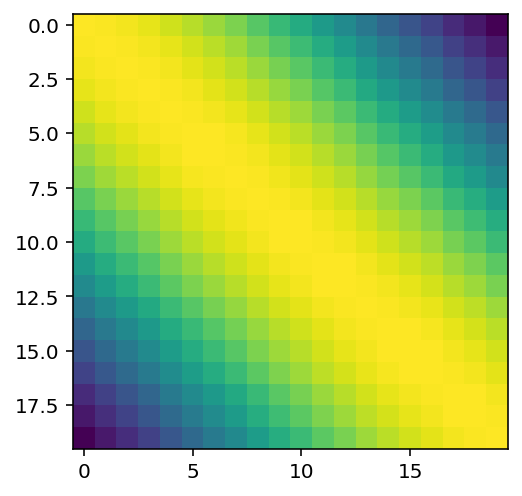

In [401]:
Phi = np.exp(-(X[np.newaxis, :] - X[:, np.newaxis]) ** 2)
plt.imshow(Phi)

In [402]:
seed(1643)
alpha = np.abs(randn(Phi.shape[1]) * 0.5)
beta, *_ = np.abs(randn(1)) * 0.5


A = np.identity(len(alpha)) * alpha
Sigma = np.linalg.inv(A + beta * Phi.T @ Phi)
m = beta * Sigma @ Phi.T @ y[:, np.newaxis]

mvn = multivariate_normal(mean=m.ravel(), cov=Sigma)

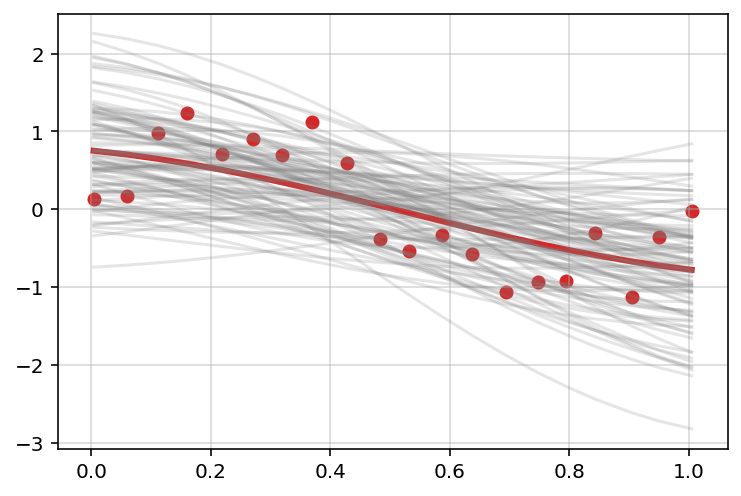

In [403]:
plt.scatter(X, y, c="tab:red")
plt.plot(X, Phi @ mvn.mean[:, np.newaxis], c="tab:red", linewidth=3)
plt.plot(X, Phi @ mvn.rvs(100).T, c="tab:gray", alpha=0.2)
plt.grid(alpha=0.5);

## Implementing the Marginal Likelihood

As of now, the hyperparameters $\alpha$, $\beta$ where randonmly chosen, we will now make use of the log-marginal likelihood to find the hyperparameters that best represent the data

In [432]:
from scipy.optimize import broyden1, fsolve, root

In [405]:
np.set_printoptions(precision=3, suppress=True)

In [486]:
poly = PolynomialFeatures(degree=10, include_bias=True)
Phi = poly.fit_transform(X[:, np.newaxis])

alpha = np.abs(randn(Phi.shape[1]))
beta, *_ = np.abs(randn(1))

In [502]:
def optimize(x, Phi):
    N, _ = Phi.shape
    beta, *alpha = x
    A = np.identity(len(alpha)) * alpha
    Sigma = np.linalg.inv(A + beta * Phi.T @ Phi)
    m = beta * Sigma @ Phi.T @ y[:, np.newaxis]
    
    gamma = 1 - alpha * np.diag(Sigma)
    x00 = 1 / beta - np.linalg.norm(y[:, np.newaxis] - Phi @ m) ** 2 / (N - gamma.sum())
    x01 = alpha - gamma / m.ravel() ** 2
    return np.r_[1 / x00, x01]

In [503]:
ans = broyden1(lambda p: optimize(p, Phi), np.r_[beta, alpha], verbose=False)

NoConvergence: [ 2.05   0.832 -0.04   5.046 -1.539  0.199 -5.648 -3.777  0.005  8.624
 -0.046 -0.907]

In [ ]:
seed(1643)

A = np.identity(len(alpha_star)) * alpha_star
Sigma = np.linalg.inv(A + beta_star * Phi.T @ Phi)
m = beta_star * Sigma @ Phi.T @ y[:, np.newaxis]

mvn = multivariate_normal(mean=m.ravel(), cov=Sigma)